# [Intriguing properties of neural networks](http://arxiv.org/abs/1312.6199)

​This paper reports two counter-intuitive properties:

- It is the **space**, rather than the individual units, that contains the semantic information in the high layers of neural networks.
- We can cause the network to **misclassify an image** by applying **a certain hardly perceptible perturbation**, which is found by maximizing the network’s prediction error. In addition, the specific nature of these perturbations is not a random artifact of learning: the same perturbation can cause a different network, that was trained on a different subset of the dataset, to misclassify the same input.

​We term the so perturbed examples “**adversarial examples**”. These results suggest that the deep neural networks that are learned by backpropagation have nonintuitive characteristics and intrinsic blind spots, **whose structure is connected to the data distribution in a non-obvious way**.

## Framework

For the MNIST dataset, we used a simple fully connected network with one or more hidden layers and a Softmax classifier. We refer to this network as “FC”.

In [1]:
import numpy as np

import torch
import torch.nn as nn
import torch.utils.data

import torchvision
import torchvision.utils as vutils
import torchvision.transforms as transforms
import torchvision.datasets as dset

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
mnist_train = dset.MNIST('./data', train=True, download=True, transform=transforms.ToTensor())
train_iter = torch.utils.data.DataLoader(mnist_train, batch_size=100, shuffle=True)
mnist_test = dset.MNIST('./data', train=False, download=True, transform=transforms.ToTensor())
test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=10000, shuffle=False)

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In order to test the cross-model generalization of adversarial examples, we define FC100_100_10 and FC10 as belows.

In [4]:
class FC100_100_10(nn.Module):
    def __init__(self):
        super(FC100_100_10, self).__init__()

        self.layer_1 = nn.Sequential(
            nn.Linear(28*28, 100),
            nn.ReLU()
        )
        
        self.layer_2 = nn.Sequential(
            nn.Linear(100, 100),
            nn.ReLU()
        )
        
        self.layer_3 = nn.Sequential(
            nn.Linear(100, 10)
        )
        
    def forward(self, x):
        x = x.view(-1, 28*28)
        
        out_1 = self.layer_1(x)
        out_2 = self.layer_2(out_1)
        out_3 = self.layer_3(out_2)
    
        return out_3, out_2, out_1
    
class FC10(nn.Module):
    def __init__(self):
        super(FC10, self).__init__()

        self.layer_1 = nn.Sequential(
            nn.Linear(28*28, 10)
        )
        
    def forward(self, x):
        x = x.view(-1, 28*28)
        
        out_1 = self.layer_1(x)
    
        return out_1

model_1=FC100_100_10().to(device)
model_2=FC10().to(device)

In [5]:
loss = nn.CrossEntropyLoss()
optimizer_1 = torch.optim.Adam([{'params': model_1.layer_1.parameters(), 'weight_decay': (1e-5)/100}, 
                                {'params': model_1.layer_2.parameters(), 'weight_decay': (1e-5)/100},
                                {'params': model_1.layer_3.parameters(), 'weight_decay': (1e-6)/10}], lr=0.001)
optimizer_2 = torch.optim.Adam(model_2.parameters(), lr=0.0001, weight_decay=1)


In [6]:
for epoch in range(10):
    for i, (images, labels) in enumerate(train_iter):
        X=images.to(device)
        Y=labels.to(device)

        pre,_,_=model_1(X)
        cost=loss(pre,Y)

        optimizer_1.zero_grad()
        cost.backward()
        optimizer_1.step()

        if (i+1)%100==0:
            print('epoch:[%d/%d], iter:[%d/%d], loss:%.5f' % (epoch+1,10,i+1,len(train_iter),cost.item()))
print('FC100_100_10 finished Training on the 60000 training images')

epoch:[1/10], iter:[100/600], loss:0.56470
epoch:[1/10], iter:[200/600], loss:0.50824
epoch:[1/10], iter:[300/600], loss:0.28815
epoch:[1/10], iter:[400/600], loss:0.17291
epoch:[1/10], iter:[500/600], loss:0.28082
epoch:[1/10], iter:[600/600], loss:0.35783
epoch:[2/10], iter:[100/600], loss:0.21052
epoch:[2/10], iter:[200/600], loss:0.33961
epoch:[2/10], iter:[300/600], loss:0.10669
epoch:[2/10], iter:[400/600], loss:0.14494
epoch:[2/10], iter:[500/600], loss:0.06286
epoch:[2/10], iter:[600/600], loss:0.07317
epoch:[3/10], iter:[100/600], loss:0.16060
epoch:[3/10], iter:[200/600], loss:0.13852
epoch:[3/10], iter:[300/600], loss:0.09653
epoch:[3/10], iter:[400/600], loss:0.05180
epoch:[3/10], iter:[500/600], loss:0.06353
epoch:[3/10], iter:[600/600], loss:0.03165
epoch:[4/10], iter:[100/600], loss:0.10778
epoch:[4/10], iter:[200/600], loss:0.02608
epoch:[4/10], iter:[300/600], loss:0.17850
epoch:[4/10], iter:[400/600], loss:0.03251
epoch:[4/10], iter:[500/600], loss:0.06791
epoch:[4/10

In [7]:
for epoch in range(10):
    for i, (images, labels) in enumerate(train_iter):
        X=images.to(device)
        Y=labels.to(device)

        pre=model_2(X)
        cost=loss(pre,Y)

        optimizer_2.zero_grad()
        cost.backward()
        optimizer_2.step()

        if (i+1)%100==0:
            print('epoch:[%d/%d], iter:[%d/%d], loss:%.5f' % (epoch+1,10,i+1,len(train_iter),cost.item()))
print('FC10 finished Training on the 60000 training images')

epoch:[1/10], iter:[100/600], loss:2.06100
epoch:[1/10], iter:[200/600], loss:1.95524
epoch:[1/10], iter:[300/600], loss:1.85405
epoch:[1/10], iter:[400/600], loss:1.79311
epoch:[1/10], iter:[500/600], loss:1.70729
epoch:[1/10], iter:[600/600], loss:1.69279
epoch:[2/10], iter:[100/600], loss:1.69097
epoch:[2/10], iter:[200/600], loss:1.65177
epoch:[2/10], iter:[300/600], loss:1.57014
epoch:[2/10], iter:[400/600], loss:1.70956
epoch:[2/10], iter:[500/600], loss:1.62389
epoch:[2/10], iter:[600/600], loss:1.65110
epoch:[3/10], iter:[100/600], loss:1.64415
epoch:[3/10], iter:[200/600], loss:1.59163
epoch:[3/10], iter:[300/600], loss:1.66574
epoch:[3/10], iter:[400/600], loss:1.67467
epoch:[3/10], iter:[500/600], loss:1.65708
epoch:[3/10], iter:[600/600], loss:1.57879
epoch:[4/10], iter:[100/600], loss:1.57898
epoch:[4/10], iter:[200/600], loss:1.63900
epoch:[4/10], iter:[300/600], loss:1.64835
epoch:[4/10], iter:[400/600], loss:1.64882
epoch:[4/10], iter:[500/600], loss:1.63320
epoch:[4/10

In [8]:
model_1.eval()

total = 0
correct = 0

for images, labels in test_loader:
    images = images.to(device)
    labels = labels.to(device)
    
    outputs,_,_ = model_1(images)
    # torch.max(outputs.data, 1)输出每一行的最大值(value, index)
    _,predicted = torch.max(outputs.data, dim=1)

    total += labels.size(0)
    correct += (predicted == labels).sum()

print('Accuracy of FC100_100_10 on the 10000 test images: %f %%' % (100 * correct / total))

Accuracy of FC100_100_10 on the 10000 test images: 97.540001 %


In [9]:
model_2.eval()

total = 0
correct = 0

for images, labels in test_loader:
    images = images.to(device)
    labels = labels.to(device)
    
    outputs = model_2(images)
    # torch.max(outputs.data, 1)输出每一行的最大值(value, index)
    _,predicted = torch.max(outputs.data, dim=1)

    total += labels.size(0)
    correct += (predicted == labels).sum()

print('Accuracy of FC10 on the 10000 test images: %f %%' % (100 * correct / total))

Accuracy of FC10 on the 10000 test images: 80.309998 %


## Units of $φ(x)$

Visual inspection of images $x′$, which satisfy (or are close to maximum attainable value):

$$
x′ = \arg \underset{x \in \mathcal{I}} {max} <φ(x),v>
$$


In [10]:
def imshow(img):
    image = img.cpu().clone().numpy()
    plt.figure(figsize=(10, 20))
    # image -> (channel, row, col)
    # plt.imshow(row,col,channel)
    plt.imshow(np.transpose(image, (1, 2, 0)))
    plt.axis('off')
    plt.show()

### in the natural basis direction

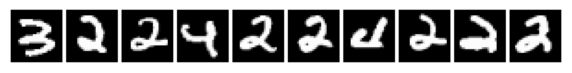

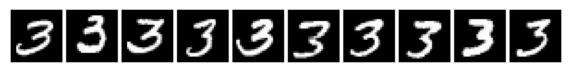

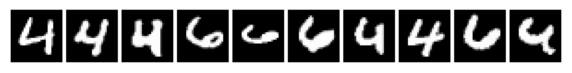

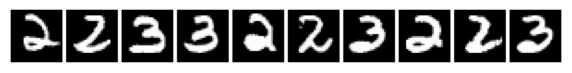

In [11]:
for i in range(4):
    unit = torch.eye(100)[i,:]

    for images, labels in test_loader:
        images = images.to(device)
        
        _,phi_x,_ = model_1(images)
        values=torch.mv(phi_x.cpu(),unit)
    
    top_index = np.argsort(values.data.numpy())[-10:]
    top_image= images[top_index]
        
    imshow(torchvision.utils.make_grid(top_image, normalize=True, pad_value=1, nrow=10))

### in a random basis

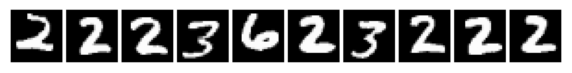

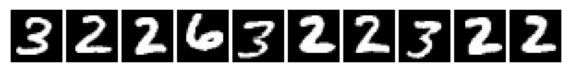

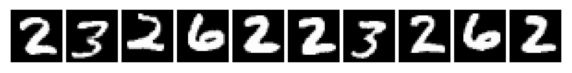

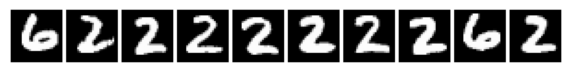

In [12]:
for i in range(4):
    direction= torch.rand(100)
    
    for images, labels in test_loader:
        images = images.to(device)
        
        _,phi_x,_ = model_1(images)
        values=torch.mv(phi_x.cpu(),direction)
    
    top_index = np.argsort(values.data.numpy())[-10:]
    top_image= images[top_index]
        
    imshow(torchvision.utils.make_grid(top_image, normalize=True, pad_value=1, nrow=10))

The experiment suggests that the natural basis is not better than a random basis for inspecting the properties of $φ(x)$. This puts into question the notion that neural networks disentangle variation factors across coordinates.

## Blind Spots in Neural Networks(“**adversarial examples**”)

For a small enough radius $ε > 0$ in the vicinity of a given training input $x$, an $x + r$ satisfying $||r|| < ε$ will get assigned a high probability of the correct class by the model. This kind of **smoothness prior** is typically valid for computer vision problems. In general, imperceptibly tiny perturbations of a given image do not normally change the underlying class.

Our main result is that for deep neural networks, the smoothness assumption that underlies many kernel methods does not hold. Specifically, we show that by using a simple optimization procedure, we are able to find adversarial examples, which are obtained by imperceptibly small perturbations to a correctly classified input image, so that it is no longer classified correctly.


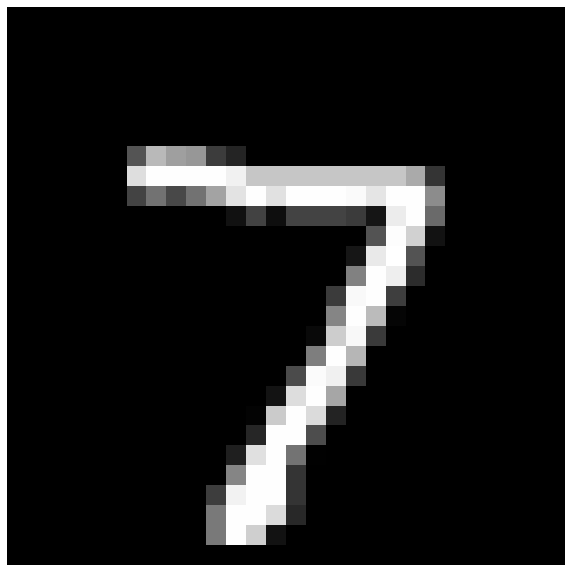

In [13]:
sample_img=mnist_test[0][0].cuda()
output,_,_=model_1(sample_img.to(device))
_,prediction=torch.max(output.data,1)
imshow(torchvision.utils.make_grid(sample_img, normalize=True))

In [14]:
def distortion(a,b):
    return torch.sqrt(torch.sum((a-b)**2)/784)

We aim to solve the following box-constrained optimization problem:

$$
\min ||r||_{2} \\s.t. \quad f(x+r)=l \\ \qquad \qquad x+r \in [0,1]^{m}
$$

or:

$$
\min c||r||_{2}+loss_{f}(x+r,l) \quad s.t. \quad x+r \in [0,1]^{m}
$$

In [15]:
right=sample_img-torch.zeros_like(sample_img).cuda()

left=sample_img-torch.ones_like(sample_img).cuda()

m=100

According to our initial observations, adversarial examples for the higher layers seemed to be significantly more useful than those on the input or lower layers. In our future work, we plan to compare these effects in a systematic manner.

Adversarial examples have the following intriguing properties:

1. For each sample, we have always managed to generate very close, visually hard to distinguish, adversarial examples that are misclassified by the original network. 

num: 0, epoch: [100/1000], prediction: 0, loss_adv: 48.74979
num: 0, epoch: [200/1000], prediction: 0, loss_adv: 33.06634
num: 0, epoch: [300/1000], prediction: 0, loss_adv: 19.08884
num: 0, epoch: [400/1000], prediction: 0, loss_adv: 5.19411
num: 0, epoch: [500/1000], prediction: 0, loss_adv: 0.01989
num: 0, epoch: [600/1000], prediction: 0, loss_adv: 0.03075
num: 0, epoch: [700/1000], prediction: 0, loss_adv: 0.00768
num: 0, epoch: [800/1000], prediction: 0, loss_adv: 0.04093
num: 0, epoch: [900/1000], prediction: 0, loss_adv: 0.01827
Attack success! The number is 0 and the distortion is 0.092026


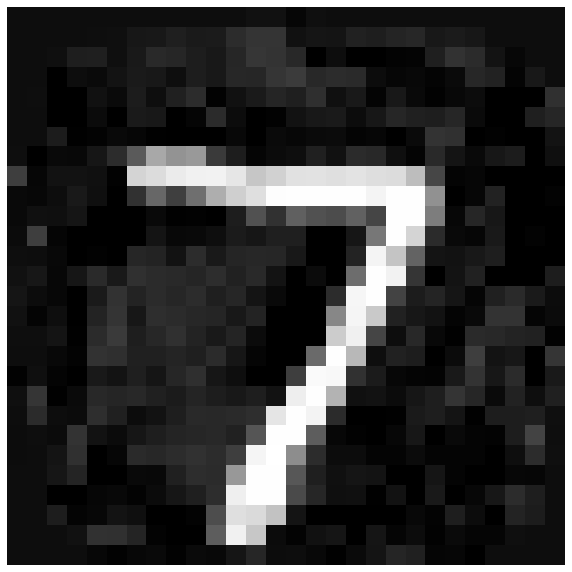

num: 1, epoch: [100/1000], prediction: 2, loss_adv: 144.04128
num: 1, epoch: [200/1000], prediction: 7, loss_adv: 125.80854
num: 1, epoch: [300/1000], prediction: 1, loss_adv: 110.51509
num: 1, epoch: [400/1000], prediction: 1, loss_adv: 95.70874
num: 1, epoch: [500/1000], prediction: 1, loss_adv: 81.08084
num: 1, epoch: [600/1000], prediction: 1, loss_adv: 66.43814
num: 1, epoch: [700/1000], prediction: 1, loss_adv: 51.78652
num: 1, epoch: [800/1000], prediction: 1, loss_adv: 37.08715
num: 1, epoch: [900/1000], prediction: 1, loss_adv: 22.32545
Attack success! The number is 1 and the distortion is 0.099231


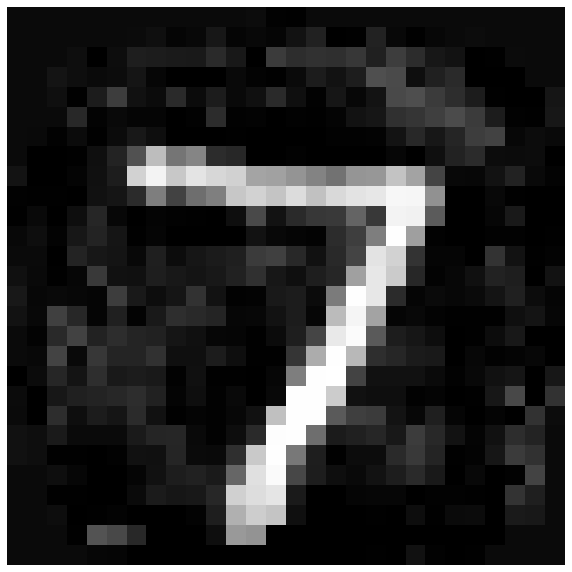

num: 2, epoch: [100/1000], prediction: 2, loss_adv: 67.32476
num: 2, epoch: [200/1000], prediction: 2, loss_adv: 51.97885
num: 2, epoch: [300/1000], prediction: 2, loss_adv: 38.29842
num: 2, epoch: [400/1000], prediction: 2, loss_adv: 24.62466
num: 2, epoch: [500/1000], prediction: 2, loss_adv: 10.84463
num: 2, epoch: [600/1000], prediction: 2, loss_adv: 0.19893
num: 2, epoch: [700/1000], prediction: 2, loss_adv: 0.04781
num: 2, epoch: [800/1000], prediction: 2, loss_adv: 0.06494
num: 2, epoch: [900/1000], prediction: 2, loss_adv: 0.04060
Attack success! The number is 2 and the distortion is 0.128658


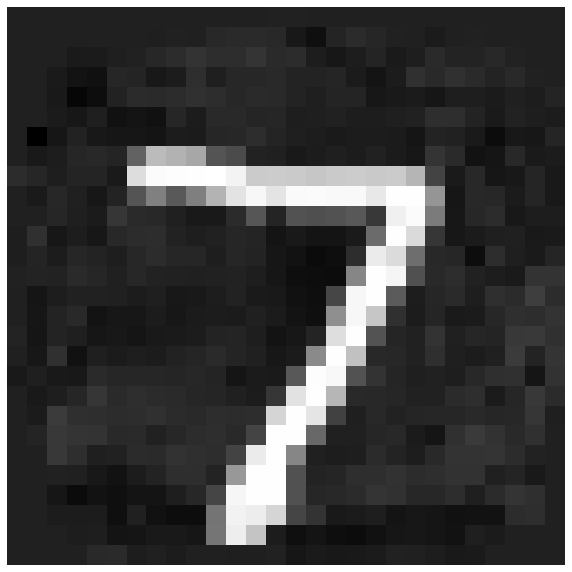

num: 3, epoch: [100/1000], prediction: 3, loss_adv: 80.32993
num: 3, epoch: [200/1000], prediction: 3, loss_adv: 64.79922
num: 3, epoch: [300/1000], prediction: 3, loss_adv: 51.16744
num: 3, epoch: [400/1000], prediction: 3, loss_adv: 37.56693
num: 3, epoch: [500/1000], prediction: 3, loss_adv: 23.88119
num: 3, epoch: [600/1000], prediction: 3, loss_adv: 10.12606
num: 3, epoch: [700/1000], prediction: 3, loss_adv: 0.08047
num: 3, epoch: [800/1000], prediction: 3, loss_adv: 0.01004
num: 3, epoch: [900/1000], prediction: 3, loss_adv: 0.00144
Attack success! The number is 3 and the distortion is 0.264297


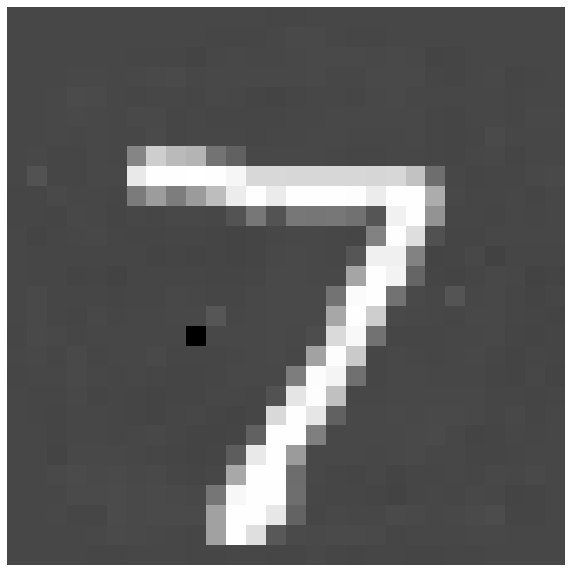

num: 4, epoch: [100/1000], prediction: 4, loss_adv: 144.55714
num: 4, epoch: [200/1000], prediction: 4, loss_adv: 126.46519
num: 4, epoch: [300/1000], prediction: 4, loss_adv: 111.23289
num: 4, epoch: [400/1000], prediction: 4, loss_adv: 96.63557
num: 4, epoch: [500/1000], prediction: 4, loss_adv: 82.21943
num: 4, epoch: [600/1000], prediction: 4, loss_adv: 67.86254
num: 4, epoch: [700/1000], prediction: 4, loss_adv: 53.48666
num: 4, epoch: [800/1000], prediction: 4, loss_adv: 39.12219
num: 4, epoch: [900/1000], prediction: 4, loss_adv: 24.72978
Attack success! The number is 4 and the distortion is 0.083023


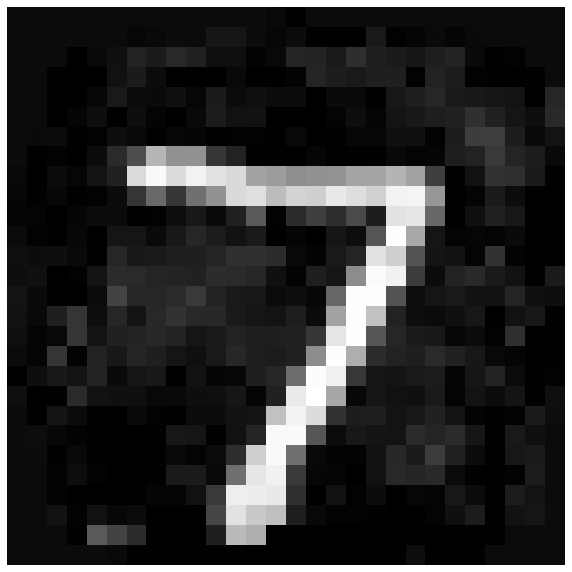

num: 5, epoch: [100/1000], prediction: 3, loss_adv: 903.99438
num: 5, epoch: [200/1000], prediction: 3, loss_adv: 880.42609
num: 5, epoch: [300/1000], prediction: 3, loss_adv: 865.48553
num: 5, epoch: [400/1000], prediction: 3, loss_adv: 851.46576
num: 5, epoch: [500/1000], prediction: 3, loss_adv: 837.56903
num: 5, epoch: [600/1000], prediction: 3, loss_adv: 823.62726
num: 5, epoch: [700/1000], prediction: 3, loss_adv: 809.68494
num: 5, epoch: [800/1000], prediction: 3, loss_adv: 795.72107
num: 5, epoch: [900/1000], prediction: 3, loss_adv: 781.74188
num: 6, epoch: [100/1000], prediction: 6, loss_adv: 101.62412
num: 6, epoch: [200/1000], prediction: 6, loss_adv: 83.80711
num: 6, epoch: [300/1000], prediction: 6, loss_adv: 68.94708
num: 6, epoch: [400/1000], prediction: 6, loss_adv: 54.44735
num: 6, epoch: [500/1000], prediction: 6, loss_adv: 40.02580
num: 6, epoch: [600/1000], prediction: 6, loss_adv: 25.58281
num: 6, epoch: [700/1000], prediction: 6, loss_adv: 11.09658
num: 6, epoch:

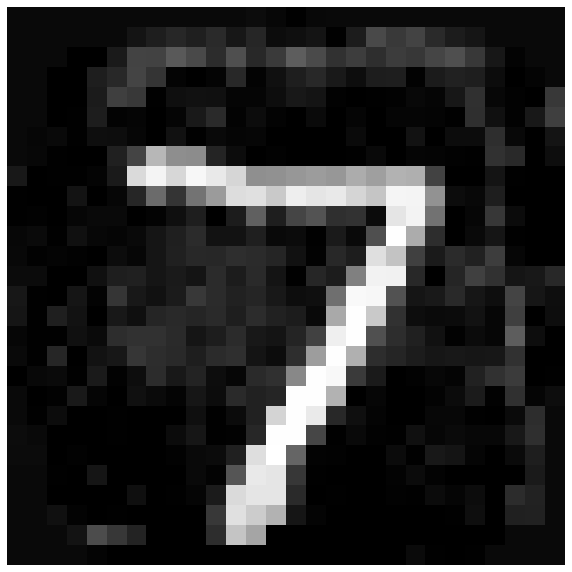

num: 7, epoch: [100/1000], prediction: 7, loss_adv: 15.67130
num: 7, epoch: [200/1000], prediction: 7, loss_adv: 2.03500
num: 7, epoch: [300/1000], prediction: 7, loss_adv: 0.01322
num: 7, epoch: [400/1000], prediction: 7, loss_adv: 0.00037
num: 7, epoch: [500/1000], prediction: 7, loss_adv: 0.01331
num: 7, epoch: [600/1000], prediction: 7, loss_adv: 0.00086
num: 7, epoch: [700/1000], prediction: 7, loss_adv: 0.01274
num: 7, epoch: [800/1000], prediction: 7, loss_adv: 0.00161
num: 7, epoch: [900/1000], prediction: 7, loss_adv: 0.01184
num: 8, epoch: [100/1000], prediction: 8, loss_adv: 19.16326
num: 8, epoch: [200/1000], prediction: 8, loss_adv: 3.95284
num: 8, epoch: [300/1000], prediction: 8, loss_adv: 0.06318
num: 8, epoch: [400/1000], prediction: 8, loss_adv: 0.01874
num: 8, epoch: [500/1000], prediction: 8, loss_adv: 0.02305
num: 8, epoch: [600/1000], prediction: 8, loss_adv: 0.06132
num: 8, epoch: [700/1000], prediction: 8, loss_adv: 0.01748
num: 8, epoch: [800/1000], prediction:

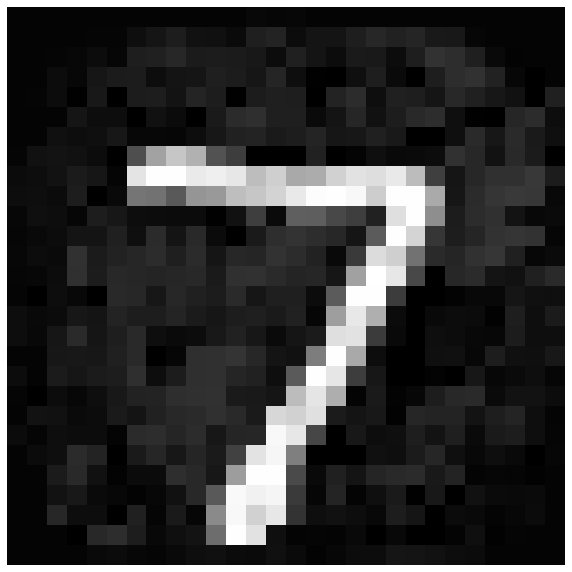

num: 9, epoch: [100/1000], prediction: 9, loss_adv: 18.27406
num: 9, epoch: [200/1000], prediction: 9, loss_adv: 3.42384
num: 9, epoch: [300/1000], prediction: 9, loss_adv: 0.03382
num: 9, epoch: [400/1000], prediction: 9, loss_adv: 0.03872
num: 9, epoch: [500/1000], prediction: 9, loss_adv: 0.07681
num: 9, epoch: [600/1000], prediction: 9, loss_adv: 0.03208
num: 9, epoch: [700/1000], prediction: 9, loss_adv: 0.03818
num: 9, epoch: [800/1000], prediction: 9, loss_adv: 0.07678
num: 9, epoch: [900/1000], prediction: 9, loss_adv: 0.03186
Attack success! The number is 9 and the distortion is 0.077891


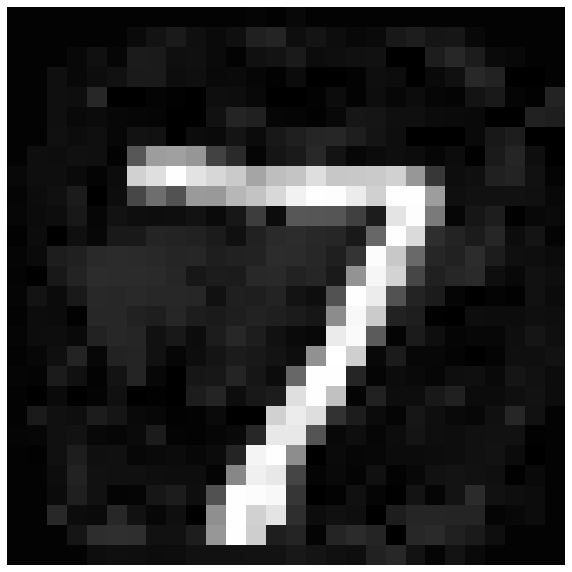

In [16]:
for num in range(10):

    r = torch.zeros_like(sample_img).cuda()
    r.requires_grad = True
    
    c = torch.rand(1).cuda()
    c = 1 / (c + 1e-10)
    c.requires_grad = True

    #optimizer_adv = torch.optim.LBFGS([r, c], lr=0.01 , line_search_fn='strong_wolfe', history_size=m)
    optimizer_adv = torch.optim.Adam([r, c], lr=0.005)
    
    for i in range(1000):

        X = sample_img.cuda() + r.cuda()
        X = (X - torch.min(X)) / (torch.max(X) - torch.min(X))
        Y = torch.tensor([num]).cuda()

        output,_,_ = model_1(X)
        _,prediction = torch.max(output.data,1)

        cost = torch.norm(r-left, p=2).cuda() + torch.norm(right-r, p=2).cuda()
        loss_adv= c.abs() * cost + loss(output,Y)

        def closure():
            return loss_adv
        
        optimizer_adv.zero_grad()
        loss_adv.backward(retain_graph=True)
        optimizer_adv.step(closure=closure)


        if (i+1) == 1000:

            if prediction.item() != 7 and prediction.item() == num:

                print('Attack success! The number is %d and the distortion is %f' % (prediction.item(), distortion(X, sample_img).item()))
                imshow(torchvision.utils.make_grid(X.data.cpu(), normalize=True))

        elif (i+1) % 100 == 0:
            print('num: %d, epoch: [%d/%d], prediction: %d, loss_adv: %.5f' % (num, i+1, 1000, prediction.item(), loss_adv.item()))

2. Cross model generalization: a relatively large fraction of examples will be misclassified by networks trained from scratch with different hyper-parameters (number of layers, regularization or initial weights). 

In [17]:
error=0
nums=0
for (sample_img, sample_num) in mnist_test:
    if nums >= 100:
        break

    sample_img=sample_img.cuda()
    for num in range(10):

        r = torch.zeros_like(sample_img).cuda()
        r.requires_grad = True
    
        c = torch.rand(1).cuda()
        c = 1 / (c + 1e-10)
        c.requires_grad = True

        #optimizer_adv = torch.optim.LBFGS([r, c], lr=0.01 , line_search_fn='strong_wolfe', history_size=m)
        optimizer_adv = torch.optim.Adam([r, c], lr=0.005)
    
        for i in range(1000):

            X = sample_img.cuda() + r.cuda()
            X = (X - torch.min(X)) / (torch.max(X) - torch.min(X))
            Y = torch.tensor([num]).cuda()

            output,_,_ = model_1(X)
            _,prediction = torch.max(output.data,1)

            cost = torch.norm(r-left, p=2).cuda() + torch.norm(right-r, p=2).cuda()
            loss_adv= c.abs() * cost + loss(output,Y)

            def closure():
                return loss_adv
        
            optimizer_adv.zero_grad()
            loss_adv.backward(retain_graph=True)
            optimizer_adv.step(closure=closure)


            if (i+1) == 1000:

                if prediction.item() != sample_num and prediction.item() == num:

                    nums += 1

                    o = model_2(X)
                    # torch.max(outputs.data, 1)输出每一行的最大值(value, index)
                    _,p_2 = torch.max(o.data, dim=1)

                    if p_2.item() != sample_num:
                        
                        error += 1
                        print('Attack success! %d is %d for model_1 and %d for model_2' % (sample_num, prediction.item(), p_2.item()))
error/nums

Attack success! 2 is 0 for model_1 and 0 for model_2
Attack success! 2 is 4 for model_1 and 6 for model_2
Attack success! 2 is 9 for model_1 and 7 for model_2
Attack success! 1 is 0 for model_1 and 7 for model_2
Attack success! 1 is 2 for model_1 and 7 for model_2
Attack success! 1 is 3 for model_1 and 7 for model_2
Attack success! 1 is 4 for model_1 and 7 for model_2
Attack success! 1 is 5 for model_1 and 7 for model_2
Attack success! 1 is 6 for model_1 and 7 for model_2
Attack success! 1 is 7 for model_1 and 7 for model_2
Attack success! 1 is 8 for model_1 and 7 for model_2
Attack success! 1 is 9 for model_1 and 7 for model_2
Attack success! 4 is 0 for model_1 and 7 for model_2
Attack success! 4 is 2 for model_1 and 7 for model_2
Attack success! 4 is 3 for model_1 and 7 for model_2
Attack success! 4 is 5 for model_1 and 7 for model_2
Attack success! 4 is 6 for model_1 and 7 for model_2
Attack success! 4 is 7 for model_1 and 7 for model_2
Attack success! 4 is 8 for model_1 and 7 for m

0.6153846153846154

3. Cross training-set generalization a relatively large fraction of examples will be misclassified by networks trained from scratch on a disjoint training set.

In [18]:
model_3=FC100_100_10().to(device)
model_4=FC100_100_10().to(device)

In [19]:
n=len(mnist_train)
train_ds1, train_ds2 = torch.utils.data.random_split(mnist_train, [int(n/2), n-int(n/2)])
train_loader1 = torch.utils.data.DataLoader(train_ds1, batch_size=100, shuffle=True)
train_loader2 = torch.utils.data.DataLoader(train_ds2, batch_size=100, shuffle=True)

In [20]:
for epoch in range(10):

    for i, (images, labels) in enumerate(train_loader1):

        X=images.to(device)
        Y=labels.to(device)

        pre,_,_=model_3(X)
        cost=loss(pre,Y)

        optimizer_1.zero_grad()
        cost.backward()
        optimizer_1.step()

        if (i+1)%100==0:
            print('epoch:[%d/%d], iter:[%d/%d], loss:%.5f' % (epoch+1,10,i+1,len(train_iter),cost.item()))
print('FC100_100_10 finished Training on the 30000 training images')

model_3.eval()

epoch:[1/10], iter:[100/600], loss:2.30302
epoch:[1/10], iter:[200/600], loss:2.30227
epoch:[1/10], iter:[300/600], loss:2.30370
epoch:[2/10], iter:[100/600], loss:2.30797
epoch:[2/10], iter:[200/600], loss:2.29934
epoch:[2/10], iter:[300/600], loss:2.30170
epoch:[3/10], iter:[100/600], loss:2.30462
epoch:[3/10], iter:[200/600], loss:2.29234
epoch:[3/10], iter:[300/600], loss:2.30905
epoch:[4/10], iter:[100/600], loss:2.29272
epoch:[4/10], iter:[200/600], loss:2.30501
epoch:[4/10], iter:[300/600], loss:2.30538
epoch:[5/10], iter:[100/600], loss:2.28617
epoch:[5/10], iter:[200/600], loss:2.29736
epoch:[5/10], iter:[300/600], loss:2.31341
epoch:[6/10], iter:[100/600], loss:2.30006
epoch:[6/10], iter:[200/600], loss:2.30520
epoch:[6/10], iter:[300/600], loss:2.29856
epoch:[7/10], iter:[100/600], loss:2.28997
epoch:[7/10], iter:[200/600], loss:2.30253
epoch:[7/10], iter:[300/600], loss:2.30578
epoch:[8/10], iter:[100/600], loss:2.30692
epoch:[8/10], iter:[200/600], loss:2.29697
epoch:[8/10

FC100_100_10(
  (layer_1): Sequential(
    (0): Linear(in_features=784, out_features=100, bias=True)
    (1): ReLU()
  )
  (layer_2): Sequential(
    (0): Linear(in_features=100, out_features=100, bias=True)
    (1): ReLU()
  )
  (layer_3): Sequential(
    (0): Linear(in_features=100, out_features=10, bias=True)
  )
)

In [21]:
for epoch in range(10):
    for i, (images, labels) in enumerate(train_loader2):
        X=images.to(device)
        Y=labels.to(device)

        pre,_,_=model_4(X)
        cost=loss(pre,Y)

        optimizer_1.zero_grad()
        cost.backward()
        optimizer_1.step()

        if (i+1)%100==0:
            print('epoch:[%d/%d], iter:[%d/%d], loss:%.5f' % (epoch+1,10,i+1,len(train_iter),cost.item()))
print('FC100_100_10\' finished Training on the 30000 training images')
model_4.eval()

epoch:[1/10], iter:[100/600], loss:2.31139
epoch:[1/10], iter:[200/600], loss:2.29938
epoch:[1/10], iter:[300/600], loss:2.30654
epoch:[2/10], iter:[100/600], loss:2.31201
epoch:[2/10], iter:[200/600], loss:2.31226
epoch:[2/10], iter:[300/600], loss:2.30756
epoch:[3/10], iter:[100/600], loss:2.30191
epoch:[3/10], iter:[200/600], loss:2.30274
epoch:[3/10], iter:[300/600], loss:2.30804
epoch:[4/10], iter:[100/600], loss:2.30996
epoch:[4/10], iter:[200/600], loss:2.31769
epoch:[4/10], iter:[300/600], loss:2.30385
epoch:[5/10], iter:[100/600], loss:2.30131
epoch:[5/10], iter:[200/600], loss:2.30894
epoch:[5/10], iter:[300/600], loss:2.31572
epoch:[6/10], iter:[100/600], loss:2.31343
epoch:[6/10], iter:[200/600], loss:2.31186
epoch:[6/10], iter:[300/600], loss:2.30913
epoch:[7/10], iter:[100/600], loss:2.30867
epoch:[7/10], iter:[200/600], loss:2.30731
epoch:[7/10], iter:[300/600], loss:2.32276
epoch:[8/10], iter:[100/600], loss:2.30626
epoch:[8/10], iter:[200/600], loss:2.30208
epoch:[8/10

FC100_100_10(
  (layer_1): Sequential(
    (0): Linear(in_features=784, out_features=100, bias=True)
    (1): ReLU()
  )
  (layer_2): Sequential(
    (0): Linear(in_features=100, out_features=100, bias=True)
    (1): ReLU()
  )
  (layer_3): Sequential(
    (0): Linear(in_features=100, out_features=10, bias=True)
  )
)

In [22]:
error=0
nums=0
for (sample_img, sample_num) in mnist_test:
    
    if nums >= 100:
        break

    sample_img=sample_img.cuda()
    for num in range(10):

        r = torch.zeros_like(sample_img).cuda()
        r.requires_grad = True
    
        c = torch.rand(1).cuda()
        c = 1 / (c + 1e-10)
        c.requires_grad = True

        #optimizer_adv = torch.optim.LBFGS([r, c], lr=0.01 , line_search_fn='strong_wolfe', history_size=m)
        optimizer_adv = torch.optim.Adam([r, c], lr=0.005)
    
        for i in range(1000):

            X = sample_img.cuda() + r.cuda()
            X = (X - torch.min(X)) / (torch.max(X) - torch.min(X))
            Y = torch.tensor([num]).cuda()

            output,_,_ = model_3(X)
            _,prediction = torch.max(output.data,1)

            cost = torch.norm(r-left, p=2).cuda() + torch.norm(right-r, p=2).cuda()
            loss_adv= c.abs() * cost + loss(output,Y)

            def closure():
                return loss_adv
        
            optimizer_adv.zero_grad()
            loss_adv.backward(retain_graph=True)
            optimizer_adv.step(closure=closure)

            if (i+1) == 1000:

                if prediction.item() != sample_num and prediction.item() == num:

                    nums += 1

                    o,_,_ = model_4(X)
                    # torch.max(outputs.data, 1)输出每一行的最大值(value, index)
                    _,p_4 = torch.max(o.data, dim=1)

                    if p_4.item() != sample_num:
                        error += 1
                        print('Attack success! %d is %d for model_3 and %d for model_4' % (sample_num, prediction.item(), p_4.item()))
error/nums

Attack success! 7 is 2 for model_3 and 6 for model_4
Attack success! 7 is 4 for model_3 and 6 for model_4
Attack success! 7 is 5 for model_3 and 6 for model_4
Attack success! 7 is 8 for model_3 and 1 for model_4
Attack success! 7 is 9 for model_3 and 6 for model_4
Attack success! 2 is 0 for model_3 and 1 for model_4
Attack success! 2 is 1 for model_3 and 6 for model_4
Attack success! 2 is 4 for model_3 and 6 for model_4
Attack success! 2 is 5 for model_3 and 1 for model_4
Attack success! 2 is 7 for model_3 and 3 for model_4
Attack success! 2 is 9 for model_3 and 6 for model_4
Attack success! 1 is 0 for model_3 and 6 for model_4
Attack success! 1 is 2 for model_3 and 6 for model_4
Attack success! 1 is 4 for model_3 and 6 for model_4
Attack success! 1 is 5 for model_3 and 6 for model_4
Attack success! 1 is 6 for model_3 and 7 for model_4
Attack success! 1 is 7 for model_3 and 3 for model_4
Attack success! 1 is 9 for model_3 and 6 for model_4
Attack success! 0 is 1 for model_3 and 6 for m

0.9611650485436893

## Spectral Analysis of Unstability

$φ_{k}$ denotes the operator mapping layer $k − 1$ to layer $k$

$φ$ denotes the output of a network of $K$ layers

Inspecting the upper Lipschitz constant, defined as the constant $L_{k} > 0$ such that 

$$
∀ x, r , ‖φ_{k}(x; W_{k}) − φ_{k}(x + r; W_{k})‖ ≤ L_{k}‖r‖
$$

The resulting network thus satsifies $‖φ(x) − φ(x + r)‖ ≤ L‖r‖$ , with $L = ∏^{K}_{k=1} L_{k}$ .



Since $ρ(x) = max(0, x)$ satisfies $∀ x, r, ‖ρ(x)−ρ(x+r)‖ ≤ ‖r‖$ , 

let $‖W‖$ denote the operator norm of $W$ ,

if $φ_{k}(x; W_{k}, b_{k}) = max(0, W_{k}x+b_{k})$ , 

then $‖φ_{k}(x; W_{k})−φ_{k}(x+r; W_{k})‖ = ‖ max(0, W_{k}x+b_{k})−max(0, W_{k}(x+r)+b_{k})‖ ≤ ‖W_{k}r‖ ≤ ‖W_{k}‖‖r‖$ , and hence $L_{k} ≤ ‖W_{k}‖$. 

For a max-pooling layer $φ_{k}$ , $∀x,r , ‖φ_{k}(x) − φ_{k}(x + r)‖ ≤ ‖r‖$.

For a contrast-normalization layer $φ_{k}(x)=\frac{x}{(\epsilon + ‖x‖^{2})^{\gamma}}$ , $∀ x , r , ‖φ_{k}(x) − φ_{k}(x + r)‖ ≤ \epsilon^{−\gamma}‖r‖$ for $\gamma \in [0.5,1]$.

If $W$ denotes a generic 4-tensor, implementing a convolutional layer with $C$ input features, $D$ output features, support $N × N$ and spatial stride $∆$,

$$
Wx=\{\sum_{c=1}^C x_{c}*w_{c,d}(n_{1}∆,n_{2}∆);d=1,...,D\}
$$

where $x_{c}$ denotes the $c$-th input feature image, and $w_{c,d}$ is the spatial kernel corresponding to input feature $c$ and output feature $d$, by applying Parseval’s formula we obtain that its operator norm is given by

$$
‖W‖=\sup_{\xi \in [0,N∆^{-1})^{2}} ‖A(\xi)‖
$$

where $A(\xi)$ is a $D × (C · ∆^{2})$ matrix whose rows are

$$
∀d = 1...D , A(\xi)_{d} = (∆^{-2}\hat{w_{c,d}}(\xi + l · N · ∆^{−1});c=1...C,l=(0...∆-1)^{2})
$$

$\hat{w_{c,d}}$ is the 2-D Fourier transform of $w_{c,d}$:

$$
\hat{w_{c,d}}(\xi)=\sum_{u \in [0,N)^{2} } w_{c,d}(u)e^{-2\pi i (u·\xi)/N^{2}}
$$

**We emphasize that we compute upper bounds: large bounds do not automatically translate into existence of adversarial examples; however, small bounds guarantee that no such examples can appear. This suggests a simple regularization of the parameters, consisting in penalizing each upper Lipschitz bound, which might help improve the generalisation error of the networks.**

## Discussion

Possible explanation is that the set of adversarial negatives is of extremely low probability, and thus is never (or rarely) observed in the test set, yet it is dense (much like the rational numbers), and so it is found near every virtually every test case. However, we don’t have a deep understanding of how often adversarial negatives appears, and thus this issue should be addressed in a future research.